# Analysis of a nonlinear global carbon cycle model

We import all necessary packages. The package [LAPM](https://github.com/MPIBGC-TEE/LAPM) treats transit-time and age densities for **L**inear **A**utonomous **P**ool **M**odels and is needed to compute the steady-state age distributions which are is used as initial age distributions in the year 1765. Then we use the [CompartmentalSystems](https://github.com/MPIBGC-TEE/CompartmentalSystems) package to compute how the age distributions change in time when the system is perturbed by the addition of fossil-fuel derived carbon to the atmosphere.

In [1]:
# file system operations
import os

# all array-like data structures are numpy.array
import numpy as np

# for 2d plots we use Matplotlib
import matplotlib.pyplot as plt

# for 3d plots we use plotly
# load plotly's jupyter notebook functions
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=False)

# symbolic treatment of reservoir models as basis of model runs
from sympy import Matrix, symbols, Symbol, Function, latex

# the input function of carbon to the atmosphere is going to be
# a linearly interpolated function of a data set
from scipy.interpolate import interp1d

# load the compartmental model packages
from LAPM.linear_autonomous_pool_model import LinearAutonomousPoolModel
from CompartmentalSystems.smooth_reservoir_model import SmoothReservoirModel
from CompartmentalSystems.smooth_model_run import SmoothModelRun

## technical part for notebook ##

# enable latex in plotly labels
from IPython.display import display, HTML, Markdown
display(HTML(
    '<script>'
        'var waitForPlotly = setInterval( function() {'
            'if( typeof(window.Plotly) !== "undefined" ){'
                'MathJax.Hub.Config({ SVG: { font: "STIX-Web" }, displayAlign: "center" });'
                'MathJax.Hub.Queue(["setRenderer", MathJax.Hub, "SVG"]);'
                'clearInterval(waitForPlotly);'
            '}}, 250 );'
    '</script>'
))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


We check whether the `output_data` folder exists and create it if not. In general, all data will be loaded from existing files in this folder. If the according file does not exist, a new computation is going to be started and afterwards the data is going to be saved in a file in this folder.

To enforce a complete new computation of all data, simply delete the `output_data` folder. Such a new computation might take a day or more, depending on the CPU speed. In particular brute force quantile computations (of backward transit times) are time consuming.

In [2]:
version = 2
folder = 'output_data_v%d/' % version
if not os.path.exists(folder):
    os.makedirs(folder)
    print("Created output data folder named '%s'" % folder)

Next, we initialize the symbols we need to represent the model.

In [3]:
########## symbol definitions ##########

# time symbol
time_symbol = symbols('t')

# Atmosphere, Terrestrial Carbon and Surface ocean
C_A, C_T, C_S = symbols('C_A C_T C_S')

# fossil fuel inputs
u_A = Function('u_A')(time_symbol)

# land use change flux
f_TA = Symbol('f_TA')(time_symbol)

# nonlinear effects
alpha, beta = symbols('alpha beta')

Now, we define the model.

In [4]:
########## model structure: equilibrium values and fluxes ##########

# equilibrium values
A_eq, T_eq, S_eq = (700.0, 3000.0, 1000.0)

state_vector = Matrix([C_A, C_T, C_S])

# fluxes
F_AT = 60*(C_A/A_eq)**alpha
F_AS = 100*C_A/A_eq
F_TA = 60*C_T/T_eq + f_TA
F_SA = 100*(C_S/S_eq)**beta

input_fluxes = {0: u_A, 1: 0, 2: 45} 
output_fluxes = {2: 45*C_S/S_eq}
internal_fluxes = {(0,1): F_AT, (0,2): F_AS,
                   (1,0): F_TA, (2,0): F_SA}

# create the SmoothReservoirModel
nonlinear_srm = SmoothReservoirModel(state_vector, 
                                     time_symbol, 
                                     input_fluxes, 
                                     output_fluxes, 
                                     internal_fluxes)

# nonlinear effects as a parameter dictionary
par_dicts = [{alpha: 0.2, beta: 10.0}, # version 0, classical
             {alpha: 0.1, beta:  5.0}, # version 1
             {alpha: 0.1, beta: 20.0}, # version 2
             {alpha: 0.4, beta:  5.0}, # version 3
             {alpha: 0.4, beta: 20.0}, # version 4
             {alpha: 1.0, beta:  1.0}] # linear version

par_dict = par_dicts[version]

We read in the fossil fuel inputs and the land use change effects from a csv file and create linear interpolation functions from the data points. Then we connect these function with the symbols from the model.

In [5]:
# fossil fuel and land use change data
ff_and_lu_data = np.loadtxt('emissions.csv', usecols = (0,1,2), skiprows = 38)

# column 0: time, column 1: fossil fuels
ff_data = ff_and_lu_data[:,[0,1]]

# linear interpolation of the (nonnegative) data points
u_A_interp = interp1d(ff_data[:,0], np.maximum(ff_data[:,1], 0))

def u_A_func(t_val):
    # here we could do whatever we want to compute the input function
    # we return only the linear interpolation from above
    return u_A_interp(t_val)

# column 0: time, column 2: land use effects
lu_data = ff_and_lu_data[:,[0,2]]
f_TA_func = interp1d(lu_data[:,0], lu_data[:,1])

# define a dictionary to connect the symbols with the according functions
func_set = {u_A: u_A_func, f_TA: f_TA_func}

We use the `SmoothReservoirModel`, the parameter dictionary, and the customly defined functions to create a `SmoothModelRun`.

In [6]:
# define the time and age windows of interest
start_year = 1765
end_year = 2500
max_age = 250

times = np.arange(start_year, end_year+1, 1)
ages = np.arange(0, max_age+1, 1)

# the system starts in equilibrium
start_values = np.array([A_eq, T_eq, S_eq])

# create the nonlinear model run
nonlinear_smr = SmoothModelRun(nonlinear_srm, par_dict, start_values, times, func_set)

# linearize the nonlinear model run along its solution trajectory
smr = nonlinear_smr.linearize()

We can plot the functions created by linear interpolation of external data.

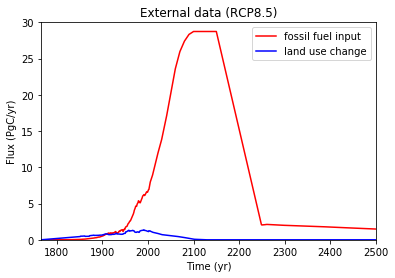

In [7]:
# plot the functions based on external data sets
plt.title('External data (RCP8.5)')
plt.plot(times, [u_A_func(t) for t in times], color='red', label='fossil fuel input')
plt.plot(times, [f_TA_func(t) for t in times], color='blue', label='land use change')
plt.xlim([1765,2500])
plt.ylim([0,30])
plt.legend(loc=1)
plt.xlabel('Time (yr)')
plt.ylabel('Flux (PgC/yr)')
plt.show()

Now, we compute the state transition operator cache and save it to a file. If this file already exists, we simply load it instead of having to recompute it. Depending on the size of the state stransition operator cache, this might take several hours. But all time we invest at this point will be saved later on during density and quantile computations.

Furthermore, we solve the linearized model and plot the solution trajectories for the different compartments.

Loading state transition operator
done


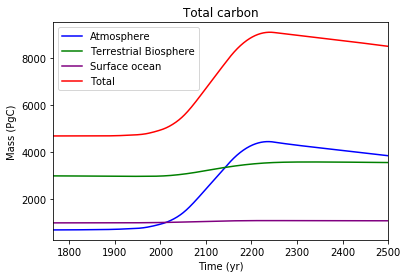

In [8]:
##### (build and save or) load state transition operator cache #####

# the cache size indicates at how many intermediate time points the
# state transition operator is going to be cached to increase
# the speed of upcoming computations massively
cache_size = 1001

try:
    print('Loading state transition operator')
    smr.load_state_transition_operator_cache(folder + '_sto.cache')
except FileNotFoundError:
    print('Building state transition operator cache')
    smr.build_state_transition_operator_cache(size = cache_size)
    print('Saving state transition operator cache')
    smr.save_state_transition_operator_cache(folder + '_sto.cache')
print('done')

# solve the linearized model
soln = smr.solve()

# plot the solution
plt.title('Total carbon')
plt.plot(times, soln[:,0], color='blue', label='Atmosphere')
plt.plot(times, soln[:,1], color='green', label='Terrestrial Biosphere')
plt.plot(times, soln[:,2], color='purple', label='Surface ocean')
plt.plot(times, soln.sum(1), color='red', label='Total')
plt.xlim([1765,2500])
plt.legend(loc=2)
plt.xlabel('Time (yr)')
plt.ylabel('Mass (PgC)')
plt.show()

We now use the `LAPM` package to compute the initial age densities and the initial mean age under the assumption that the system is in steady state in the year 1765.

In [9]:
##### load linear autonomous pool model in steady state #####

# rhs = xi*T*N*C + u
xi, T, N, C, u = nonlinear_srm.xi_T_N_u_representation

# B = xi*T*N, plug in the steady-state initial contents
# no land use change flux
B = (xi*T*N).subs(par_dict).subs({C_A: A_eq, C_T: T_eq, C_S: S_eq, f_TA: 0})

# no fossil fuel inputs
u = u.subs(par_dict).subs({u_A: 0})

# force purely numerical treatment of the LAPM
# symbolic treatment would be too slow here
LM = LinearAutonomousPoolModel(u, B, force_numerical=True)

## load equilibrium age densities ##

# the start age densities are given as a function of age that returns
# a vector of mass with that age
def start_age_densities(a):
    # we need to convert from sympy data types to numpy data types
    res =  np.array(LM.a_density(a)).astype(np.float64).reshape((3,)) * start_values
    return res

# get the start mean ages
start_mean_ages = np.array(LM.a_expected_value).astype(np.float64).reshape((3,))
start_age_moments = start_mean_ages.reshape((1,3))

We can now plot the initial age distributions. These are the equilibrium age densities in the year 1765.

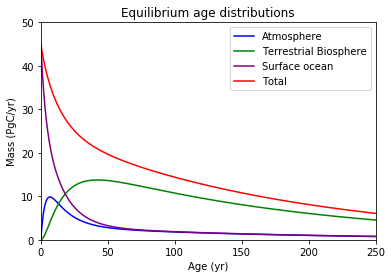

In [10]:
plt.title('Equilibrium age distributions')
y = np.array([start_age_densities(a) for a in ages])
plt.plot(ages, y[:,0], color='blue', label='Atmosphere')
plt.plot(ages, y[:,1], color='green', label='Terrestrial Biosphere')
plt.plot(ages, y[:,2], color='purple', label='Surface ocean')
plt.plot(ages, y.sum(1), color='red', label='Total')
plt.legend()
plt.xlabel('Age (yr)')
plt.ylabel('Mass (PgC/yr)')
plt.xlim([0, 250])
plt.ylim([0, 50])
plt.show()

Now, we compute the age densities of the system that is perturbed by fossil fuel input and land use change.
We further create according figure objects to which we will later add also a transparent equilibrium surface and mean and median lines.

In [11]:
try:
    print('Loading age densities')
    age_densities = smr.load_pools_and_system_densities_csv(folder + 'age_dens.csv', ages)
    pool_age_densities = age_densities[:,:,:smr.nr_pools]
    system_age_density = age_densities[:,:,smr.nr_pools]
except FileNotFoundError:
    print('Computing age densities')
    p = smr.pool_age_densities_func(start_age_densities)
    pool_age_densities = p(ages)
    
    print('Saving age densities')
    system_age_density = smr.system_age_density(pool_age_densities)
    smr.save_pools_and_system_density_csv(folder + 'age_dens.csv', pool_age_densities, system_age_density, ages)
    
    # combine pool and system age densities to one numpy array
    age_densities = smr.age_densities(pool_age_densities, system_age_density)
print('done')
    
# plotting coarsity in age and time direction for saving memory
age_stride = 10
time_stride = 10

pools = range(smr.nr_pools)
# create the figures of the compartment and system age densities
figs = []
titles = ["$" + latex(smr.model.state_vector[pool]) + "$" for pool in pools] + ["Total"]
for k in range(smr.nr_pools+1):
    fig = smr.plot_3d_density_plotly(titles[k], 
                                     age_densities[:,:,k], 
                                     ages, 
                                     age_stride=age_stride,
                                     time_stride=time_stride)
    figs.append(fig)
    
# plot the densities
#for fig in figs: 
#    iplot(fig)

Loading age densities
done


Let us add transparent equilibrium surfaces to the density plots.

In [12]:
for fig in figs:
    smr.add_equilibrium_surface_plotly(fig, opacity=0.7)
    
# plot the densities with added equilibrium surfaces
#for fig in figs:
#    iplot(fig)

We also compute the mean ages and the age medians for the different compartments and the system.

In [13]:
##### mean ages #####
try:
    print('Loading mean ages')
    pool_age_mean, system_age_mean = smr.load_pools_and_system_value_csv(folder + 'age_mean.csv')
except FileNotFoundError:
    print('Computing mean ages')
    pool_age_mean = smr.age_moment_vector(1, start_age_moments)
    system_age_mean = smr.system_age_moment(1, start_age_moments)
    print('Saving mean ages')
    smr.save_pools_and_system_value_csv(folder + 'age_mean.csv', pool_age_mean, system_age_mean)
print('done')

##### age medians #####

# set a tolerance for the quantile precision
# the smaller the more precise and the slower
tol = 1e-1

# start cumulative mass functions of age
# to have it available allows faster computations,
# since we save tedious numerical integrations
def F0(a):
    res = np.array(LM.a_cum_dist_func(a)).astype(np.float64).reshape((3,)) * start_values
    return res

try:
    print('Loading age medians')
    pool_age_median, system_age_median = smr.load_pools_and_system_value_csv(folder + 'age_median.csv')
except FileNotFoundError:
    print('Computing age medians')
    pool_age_median = smr.pool_age_distributions_quantiles_by_ode(0.5, start_age_densities=start_age_densities, F0=F0, tol=tol)
    system_age_median = smr.system_age_distribution_quantiles_by_ode(0.5, start_age_densities=start_age_densities, F0=F0, tol=tol)
    smr.save_pools_and_system_value_csv(folder + 'age_median.csv', pool_age_median, system_age_median)
print('done')


Loading mean ages
done
Loading age medians
done


We add the mean and the median lines to the density plots and finally execute the plots.

In [14]:
# combine pool and system mean ages and age medians
age_mean = smr.combine_pools_and_system_values(pool_age_mean, system_age_mean)
age_median = smr.combine_pools_and_system_values(pool_age_median, system_age_median)

# add mean and median lines to the figures
def add_mean_and_median_lines_to_figure(fig, mean = None, median = None, mean_title = None, median_title = None, index = 0):
    # mean age lines
    if mean is not None:
        smr.add_line_to_density_plot_plotly(fig, mean, '#0000FF', mean_title, 
                                            time_stride=time_stride,
                                            on_surface=True,
                                            bottom=True,
                                            legend_on_surface=True,
                                            legend_bottom=False
                                            )

        # equilibrium mean age line
        values = mean[index] * np.ones_like(times)
        smr.add_line_to_density_plot_plotly(fig, values, '#CCCCCC', 'equilibrium', 
                                            time_stride=time_stride,
                                            on_surface=False,
                                            bottom=True,
                                            legend_bottom=False
                                            )
        
    # age median lines
    if median is not None:
        smr.add_line_to_density_plot_plotly(fig, median, '#FF0000', median_title, 
                                            time_stride=time_stride,
                                            on_surface=True,
                                            bottom=True,
                                            legend_on_surface=True,
                                            legend_bottom=False
                                            )
    
        # equilibrium age median line
        values = median[index] * np.ones_like(times)
        smr.add_line_to_density_plot_plotly(fig, values, '#CCCCCC', 'equilibrium', 
                                            time_stride=time_stride,
                                            on_surface=False,
                                            bottom=True,
                                            legend_bottom=True
                                            )
                    

for nr in range(len(figs)):
    fig = figs[nr]
    add_mean_and_median_lines_to_figure(fig, age_mean[:,nr], age_median[:,nr], 'mean age', 'age median')

In [15]:
# finally plot the figures
for fig in figs:
    fig['layout']['legend'] = dict(x=0.8, y=0.8)
    iplot(fig)

In [16]:
s = "In the year 2017, the mean age of carbon in the atmosphere is"
s += " %1.2f yr" % age_mean[2017-1765, 0]
s += " and the median age is equal to"
s += " %1.2f yr." % age_median[2017-1765, 0]
display(Markdown(s))

In the year 2017, the mean age of carbon in the atmosphere is 125.85 yr and the median age is equal to 59.75 yr.

### Second moments

We can also compute higher order moments of the age distributions. 
To that end, we need to provide initial age moments of the same order.

In [17]:
##### second moment #####

try:
    print('Loading second order age moment')
    pool_age_moment_2, system_age_moment_2 = smr.load_pools_and_system_value_csv(folder + 'age_mmoment_2.csv')
except FileNotFoundError:
    print('Computing second order age moment')
    # set up the initial age moments of second order
    start_age_moment_2 = np.array(LM.a_nth_moment(2)).astype(np.float64).reshape((3,))
    start_age_moments = np.array([start_mean_ages, start_age_moment_2])

    # compute the age moment vector of second order
    pool_age_moment_2 = smr.age_moment_vector(2, start_age_moments)
    system_age_moment_2 = smr.system_age_moment(2, start_age_moments)
    smr.save_pools_and_system_value_csv(folder + 'age_moment_2.csv', pool_age_moment_2, system_age_moment_2)
print('done')

Loading second order age moment
Computing second order age moment
done


In [18]:
s = "The standard deviation of the atmosphere's carbon age in 2017 equals"
s += " %1.2f yr" % np.sqrt(pool_age_moment_2[2017-1765, 0]-pool_age_mean[2017-1765, 0]**2)
s += " , indicating that the distribution has a long tail."
display(Markdown(s))

The standard deviation of the atmosphere's carbon age in 2017 equals 161.36 yr , indicating that the distribution has a long tail.

## Backward transit time

We turn to the backward transit time, i.e. the age of particles at the moment they are leaving the system.
We are interested in the density, the mean, and the median of the backward transit time of the total mass that ever came into the system. We start with the density. We can profit from the already computed compartment age densities.

In [19]:
###### backward transit time #####
try:
    print('Loading backward transit time density')
    btt_density = smr.load_density_csv(folder + 'btt_dens.csv', ages)
except FileNotFoundError:
    print('Computing backward transit time density')
    btt_density = smr.backward_transit_time_density(pool_age_densities)
    print('Saving backward transit time density')
    smr.save_density_csv(folder + 'btt_dens.csv', btt_density, ages)
print('done')

btt_dens_fig = smr.plot_3d_density_plotly('Backward transit time', btt_density, ages, age_stride, time_stride)
smr.add_equilibrium_surface_plotly(btt_dens_fig, opacity=0.7)

# plot the density
#iplot(btt_dens_fig)

Loading backward transit time density
done


Now we turn to the mean.
Since the expected value is linear and all compartments are well mixed, the mean can be computed as a weighted average of the compartmental ages and their outflows.
The outflows are given in terms of the outflow rates and the compartment contents.

In [20]:
try:
    print('Loading backward transit time mean')
    btt_mean = np.loadtxt(folder + 'btt_mean.csv', usecols = (1,), delimiter = ',', skiprows = 1)
except FileNotFoundError:
    print('Computing mean backward transit time')
    start_age_moments = start_mean_ages.reshape((1,3))
    btt_mean = smr.backward_transit_time_moment(1, start_age_moments)
    print('Saving mean backward transit time')
    smr.save_value_csv(folder + 'btt_mean.csv', btt_mean)
print('done')

Loading backward transit time mean
done


Unfortunately, the median as a quantile does not behave linearly like the mean.
Consequently, the backward transit time median has to be computed by brute force. 
This is done by computing the generalized inverse of the (not normalized) cumulative distribution function `F_btt_sv` in each time step.

In [21]:
try:
    print('Loading backward transit time median')
    btt_median = np.loadtxt(folder + 'btt_median.csv', usecols = (1,), delimiter = ',', skiprows = 1)
except FileNotFoundError:
    print('Computing backward transit time median')
    F_btt_sv = smr.cumulative_backward_transit_time_distribution_single_value(F0=F0)
    btt_median = smr.distribution_quantiles(0.5, 
                                            F_btt_sv, 
                                            norm_consts = smr.external_output_vector.sum(1), 
                                            start_values = btt_mean, 
                                            method = 'brentq', 
                                            tol = tol)
    print('Saving backward transit time median')
    smr.save_value_csv(folder + 'btt_median.csv', btt_median)
print('done')

Loading backward transit time median
done


We add the mean and the median lines to he density figure.

In [22]:
# add mean and median lines to the figure
add_mean_and_median_lines_to_figure(btt_dens_fig, btt_mean, btt_median, 'BTT mean', 'BTT median')

In [23]:
btt_dens_fig['layout']['legend'] = dict(x=0.8, y=0.8)
iplot(btt_dens_fig)

## Forward transit time

The forward transit time tells (at the moment of entry) the future age particles will have when they leave the system.
We cannot compute the mean for this quantity, since we do not know the future behavior of the system until eterntity, but only till 2500.
Nevertheless, we can compute the median until a certain point in the future.

In [24]:
###### forward transit time #####
try:
    print('Loading forward transit time density')
    ftt_density = smr.load_density_csv(folder + 'ftt_dens.csv', ages)
except FileNotFoundError:
    print('Computing forward transit time density')
    ftt_density_func = smr.forward_transit_time_density_func()
    ftt_density = ftt_density_func(ages)
    smr.save_density_csv(folder + 'ftt_dens.csv', ftt_density, ages)
print('done')

# create forward transit time density figure
ftt_dens_fig = smr.plot_3d_density_plotly('Forward transit time', ftt_density, ages, age_stride, time_stride)
# we have to copy the first index here, since at index 0 (time=1765) the input is still 0 and hence
# the ftt_density is np.nan
smr.add_equilibrium_surface_plotly(ftt_dens_fig, opacity=0.7, index=1)

# plot the density
#iplot(btt_dens_fig)

Loading forward transit time density
done


Again, we compute the median by brute force.

In [25]:
try:
    print('Loading forward transit time median')
    ftt_median = np.loadtxt(folder + 'ftt_median.csv', usecols = (1,), delimiter = ',', skiprows = 1)
except FileNotFoundError:
    print('Computing forward transit time median')
    F_ftt_sv = smr.cumulative_forward_transit_time_distribution_single_value()
    # start_values slighty above the true value lead to a computation
    # in time to the right as far as possible, try to guess well, 55 is a good guess here
    ftt_median = smr.distribution_quantiles(0.5, 
                                            F_ftt_sv, 
                                            norm_consts = smr.external_input_vector.sum(1), 
                                            start_values = [55]*len(times), 
                                            method = 'brentq', 
                                            tol = tol)
    print('Saving forward transit time median')
    smr.save_value_csv(folder + 'ftt_median.csv', ftt_median)
print('done') 

Loading forward transit time median
done


We add the median lines to the density figure.

In [26]:
# add mean and median lines to the figure
add_mean_and_median_lines_to_figure(ftt_dens_fig, 
                                    mean = None, 
                                    median = ftt_median, 
                                    median_title = 'FTT median', index = 1)


In [27]:
ftt_dens_fig['layout']['legend'] = dict(x=0.8, y=0.8)
iplot(ftt_dens_fig)

We also save the total input and output fluxes to be able to compute normalized forward and backward transit time densities (probability density functions).

In [28]:
smr.save_pools_and_system_value_csv(folder + 'input_flux.csv', smr.external_input_vector, smr.external_input_vector.sum(1))
smr.save_pools_and_system_value_csv(folder + 'output_flux.csv', smr.external_output_vector, smr.external_output_vector.sum(1))

## Subsystem of only fossil fuel derived carbon

We can compute all such densities also for the subsystem that deals only with the fossil-fuel derived carbon.
To that end, we initialize another `SmoothReservoirModel` and `SmoothModelRun`, `srm_ff_only` and `smr_ff_only`, using the original solution trajectory, but changing the input vector `u`.
We suppress the inputs coming from the deep ocean and look only what happens to the fossil-fuel inputs that come directly to the atmosphere.

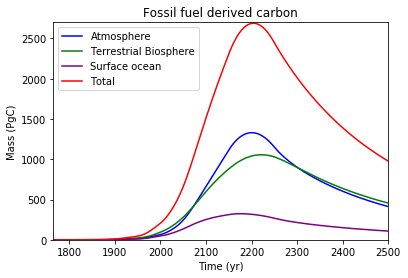

In [29]:
xi, T, N, C, u = smr.model.xi_T_N_u_representation
B = xi*T*N

# consider fossil fuel input only, no deep ocean input
u[2] = 0 

# set up fossil fuel only system
start_values_ff_only = np.zeros((3,)) # no fossil fuels in the system in 1765

srm_ff_only = SmoothReservoirModel.from_B_u(state_vector, time_symbol, B, u)
smr_ff_only = SmoothModelRun(srm_ff_only, smr.parameter_set, start_values_ff_only, smr.times, smr.func_set)

# the trick is to use the same state transition operator as before
# --> the fossil fuel carbon moves through the system as if all other carbon were there, too
smr_ff_only.load_state_transition_operator_cache(folder + '_sto.cache')

soln_ff_only = smr_ff_only.solve()
# plot the solution
plt.title('Fossil fuel derived carbon')
plt.plot(times, soln_ff_only[:,0], color='blue', label='Atmosphere')
plt.plot(times, soln_ff_only[:,1], color='green', label='Terrestrial Biosphere')
plt.plot(times, soln_ff_only[:,2], color='purple', label='Surface ocean')
plt.plot(times, soln_ff_only.sum(1), color='red', label='Total')
plt.xlim([1765,2500])
plt.ylim([0, 2700])
plt.legend(loc=2)
plt.xlabel('Time (yr)')
plt.ylabel('Mass (PgC)')
plt.show()

Now we compute the age densities of the fossil fuel only system.

In [30]:
##### ff_only age densities #####
try:
    print('Loading ff_only age densities')
    age_densities_ff_only = smr_ff_only.load_pools_and_system_densities_csv(folder + 'age_dens_ff_only.csv', ages)
    pool_age_densities_ff_only = age_densities_ff_only[:,:,:smr_ff_only.nr_pools]
    system_age_density_ff_only = age_densities_ff_only[:,:,smr_ff_only.nr_pools]
except FileNotFoundError:
    # omitting the start_age_densities means all initial mass has age 0,
    # but there is no initial massc because in the year 1765 no fossil fuels are in the system
    p_ff_only = smr_ff_only.pool_age_densities_func()
    print('Computing ff_only age densities')
    pool_age_densities_ff_only = p_ff_only(ages)
    
    print('Saving ff_only age densities')
    system_age_density_ff_only = smr_ff_only.system_age_density(pool_age_densities_ff_only)
    smr_ff_only.save_pools_and_system_density_csv(folder + 'age_dens_ff_only.csv', pool_age_densities_ff_only, system_age_density_ff_only, ages)
    
    # combine pool and system age densities to one numpy array
    age_densities_ff_only = smr_ff_only.age_densities(pool_age_densities_ff_only, system_age_density_ff_only)
print('done')

pools = range(smr_ff_only.nr_pools)
# create the figures of the ff_only compartment and system age densities
figs = []
titles = ["$" + latex(smr_ff_only.model.state_vector[pool]) + "$" for pool in pools] + ["Total"]
for k in range(smr_ff_only.nr_pools+1):
    fig = smr_ff_only.plot_3d_density_plotly(titles[k], 
                                             age_densities_ff_only[:,:,k], 
                                             ages, 
                                             age_stride=age_stride,
                                             time_stride=time_stride)
    figs.append(fig)
    
# plot the densities
#for fig in figs: 
#    iplot(fig)

Loading ff_only age densities
done


We also compute the mean ages and the age medians for the different compartments and the system.

In [31]:
##### ff_only mean ages #####
try:
    print('Loading ff_only mean ages')
    pool_age_mean_ff_only, system_age_mean_ff_only = smr_ff_only.load_pools_and_system_value_csv(folder + 'age_mean_ff_only.csv')
except FileNotFoundError:
    print('Computing ff_only mean ages')
    pool_age_mean_ff_only = smr_ff_only.age_moment_vector(1)
    system_age_mean_ff_only = smr_ff_only.system_age_moment(1)
    print('Saving ff_only mean ages')
    smr_ff_only.save_pools_and_system_value_csv(folder + 'age_mean_ff_only.csv', 
                                                pool_age_mean_ff_only,
                                                system_age_mean_ff_only)
print('done')
    
##### ff_only age medians #####
try:
    print('Loading ff_only age medians')
    pool_age_median_ff_only, system_age_median_ff_only = smr_ff_only.load_pools_and_system_value_csv(folder + 'age_median_ff_only.csv')
except FileNotFoundError:
    print('Computing ff_only age medians')
    pool_age_median_ff_only = smr_ff_only.pool_age_distributions_quantiles_by_ode(0.5, tol=tol)
    system_age_median_ff_only = smr_ff_only.system_age_distribution_quantiles_by_ode(0.5, tol=tol)
    print('Saving ff_only age medians')
    smr_ff_only.save_pools_and_system_value_csv(folder + 'age_median_ff_only.csv',
                                                pool_age_median_ff_only, 
                                                system_age_median_ff_only)
print('done')

Loading ff_only mean ages
done
Loading ff_only age medians
Computing ff_only age medians
Pool: 0


100%|██████████| 734.0/734 [48:16<00:00,  4.10s/it]            


Pool: 1


 31%|███       | 226.832306514/734 [06:57<24:48,  2.93s/it]   

Error: Evaluation before t0 is not possible

We add the mean and the median lines to the density plots and finally execute the plots.

In [ ]:
# combine pool and system mean ages and age medians
age_mean_ff_only = smr_ff_only.combine_pools_and_system_values(pool_age_mean_ff_only, system_age_mean_ff_only)
age_median_ff_only = smr_ff_only.combine_pools_and_system_values(pool_age_median_ff_only, system_age_median_ff_only)
    
# add equilibrium surfaces and mean and median lines to the figures
for nr in range(len(figs)):
    fig = figs[nr]
    smr_ff_only.add_equilibrium_surface_plotly(fig, opacity=0.7)
    add_mean_and_median_lines_to_figure(fig, 
                                        age_mean_ff_only[:,nr],
                                        age_median_ff_only[:,nr], 
                                        'fossil fuel carbon mean age', 
                                        'fosil fuel carbon age median')

In [ ]:
# finally plot the figures
for fig in figs:
    fig['layout']['legend'] = dict(x=0.8, y=0.8)
    iplot(fig)

### Backward transit time

We make now use of the fact that the backward transit time distribution coincides with the age distribution of the surface ocean, since mass can only leave the system through the surface ocean compartment.
Consequently, we do not need to compute anything new here.

In [ ]:
###### backward transit time #####
btt_density_ff_only = pool_age_densities_ff_only[:,:,2]
btt_mean_ff_only = pool_age_mean_ff_only[:,2]
btt_median_ff_only = pool_age_median_ff_only[:,2]

We can now show how the mean (median) ages at the moment of exit of the total carbon and the only from fossil fuels derived carbon evolve in time.

In [ ]:
plt.plot(times, btt_mean, color = 'blue', ls = '-', label = 'mean BTT, total C')
plt.plot(times, btt_median, color = 'red', ls = '-', label = 'median BTT, total C')
plt.plot(times, btt_mean_ff_only, color = 'blue', ls = '--', label = 'mean BTT, fossil fuel C')
plt.plot(times, btt_median_ff_only, color = 'red', ls = '--', label = 'median BTT, fossil fuel C')
plt.xlim([1765,2500])
plt.legend(loc=2)
plt.xlabel('Time (yr)')
plt.ylabel('Age (yr)')
plt.show()

### Hypothetical forward transit time

We consider what happens to a hypothetically injected amount of $1\,$PgC: how long does it take to be removed from the system?
To that end, we construct another `SmoothReservoirModel` and `SmoothModelRun` called `srm_const_f` and `smr_const_ff` respectively, by setting the fossil fuel input constant to $1\,$PgC.
We still use the original state transition operator, consequently the carbon added to this system acts like it would have been injected into the original system.

In [ ]:
########## hyopthetical input of 1 PgC each year: forward transit time of fossil fuel carbon  ##########

xi, T, N, C, u = smr.model.xi_T_N_u_representation
B = xi*T*N

# fossil fuels only as inputs, and constant
u[0] = 1
u[2] = 0 

# constant fossil fuels system
start_values_const_ff = np.zeros((3,))

srm_const_ff = SmoothReservoirModel.from_B_u(state_vector, time_symbol, B, u)
smr_const_ff = SmoothModelRun(srm_const_ff, smr.parameter_set, start_values_const_ff, smr.times, smr.func_set)
smr_const_ff.load_state_transition_operator_cache(folder + '_sto.cache')

try:
    print('Loading const_ff forward transit time density')
    ftt_density_const_ff = smr_const_ff.load_density_csv(folder + 'ftt_dens_const_ff.csv', ages)
except FileNotFoundError:
    print('Computing const_ff forward transit time density')
    ftt_density_func_const_ff = smr_const_ff.forward_transit_time_density_func() 
    ftt_density_const_ff = ftt_density_func_const_ff(ages)
    smr_const_ff.save_density_csv(folder + 'ftt_dens_const_ff.csv', ftt_density_const_ff, ages)
print('done')

try:
    print('Loading const_ff forward transit time median')
    ftt_median_const_ff = np.loadtxt(folder + 'ftt_median_const_ff.csv', usecols = (1,), delimiter = ',', skiprows = 1)
except FileNotFoundError:
    print('Computing const_ff forward transit time median')
    F_ftt_sv_const_ff = smr_const_ff.cumulative_forward_transit_time_distribution_single_value()
    ftt_median_const_ff = smr_const_ff.distribution_quantiles(0.5, 
                                                              F_ftt_sv_const_ff, 
                                                              norm_consts=smr_const_ff.external_input_vector.sum(1), 
                                                              start_values=[110]*len(times), 
                                                              method='brentq', 
                                                              tol=tol)
    print('Saving const_ff forward transit time median')
    smr_const_ff.save_value_csv(folder + 'ftt_median_const_ff.csv', ftt_median_const_ff)
print('done')

We can now cut out the years of interest and see how the forward transit time distribution of fossil fuel carbon changes over time.

In [ ]:
years = [1800, 1990, 2015, 2170, 2300]
labels = ['1800', '1990 (Kyoto Protocol)', '2015 (Paris Agreement)', '2170 (max. median)', '2300']
colors = ['red', 'blue', 'green', 'purple', 'orange']

plt.title('Future exit age of 1 incoming PgC')
for k in range(len(years)):
    year = years[k]
    color = colors[k]
    label = labels[k]
    plt.plot(ages, ftt_density_const_ff[:,year-1765], color = color, label = label)
    
    # add vertical median lines
    median = ftt_median_const_ff[year-1765]
    dens_val = ftt_density_const_ff[int(median),year-1765]
    plt.plot((median, median), (0, dens_val), color = color, ls = '--')

plt.legend(loc=0)
plt.xlabel('Age (yr)')
plt.ylabel('Mass (PgC/yr)')
plt.xlim([0, 250])
plt.ylim([0,0.015])
plt.show()

In [ ]:
s = "The dashed medians are given by "
s += ", ".join(["%01.2f yr" % ftt_median_const_ff[year-1765] for year in years]) + "."
display(Markdown(s))